In [1]:
import os, time
import numpy as np
import random
random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
torch.manual_seed(42)
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision.models import resnet
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pprint import pprint

import torch.optim as optim
from tqdm import tqdm

In [2]:
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 2.5.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40, uuid=b048b9b3-a835-1f9c-9522-ced2f515aa65, L2_cache_size=4MB)


# **Load Data**

In [3]:
import tarfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# tar_file_path = "/content/drive/MyDrive/kerja/testiing/soal_2/data/images.tar"
# extract_to_path = "/content/drive/MyDrive/kerja/testiing/soal_2/data/"

# with tarfile.open(tar_file_path, "r") as tar:
#     tar.extractall(path=extract_to_path)

# **Transform Data**

In [4]:
def load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std):
    train_transform = transforms.Compose([
                                         transforms.Resize((224,224)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(torch.Tensor(mean),
                                                              torch.Tensor(std))])

    test_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean),
                                                             torch.Tensor(std))])

    val_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean),
                                                            torch.Tensor(std))])

    dataset = datasets.ImageFolder(root=images_path, transform=train_transform)
    train_size = int(train_split * len(dataset))
    test_size = int(test_split * len(dataset))
    val_size = len(dataset) - train_size - test_size
    training_set, testing_set, validation_set = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

    training_set_loader = DataLoader(training_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    validation_set_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    testing_set_loader = DataLoader(testing_set, batch_size=batch_size, num_workers=threads, shuffle=False)

    return training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set

In [5]:
# Parameter
images_path = "/content/drive/MyDrive/kerja/testiing/soal_2/data/Images"
presplit = False  # Karena dataset belum dibagi ke train/val/test, set presplit=False
train_split = 0.5
test_split = 0.25
val_split = 0.25
batch_size = 64
threads = 4
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Load dataset
train_loader, test_loader, val_loader, dataset, train_set, test_set, val_set = load_transform_images(
    images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std
)

# Cek jumlah data
print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_set)}")
print(f"Testing set size: {len(test_set)}")
print(f"Validation set size: {len(val_set)}")

Total dataset size: 20580
Training set size: 10290
Testing set size: 5145
Validation set size: 5145


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
class_names = dataset.classes
class_names = [classes[10:] for classes in class_names]
pprint(class_names)

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih-Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black-and-tan_coonhound',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Italian_greyhound',
 'whippet',
 'Ibizan_hound',
 'Norwegian_elkhound',
 'otterhound',
 'Saluki',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire-haired_fox_terrier',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft-coated_wheaten_terrier',
 'West_Highland_wh

# **Example Images**

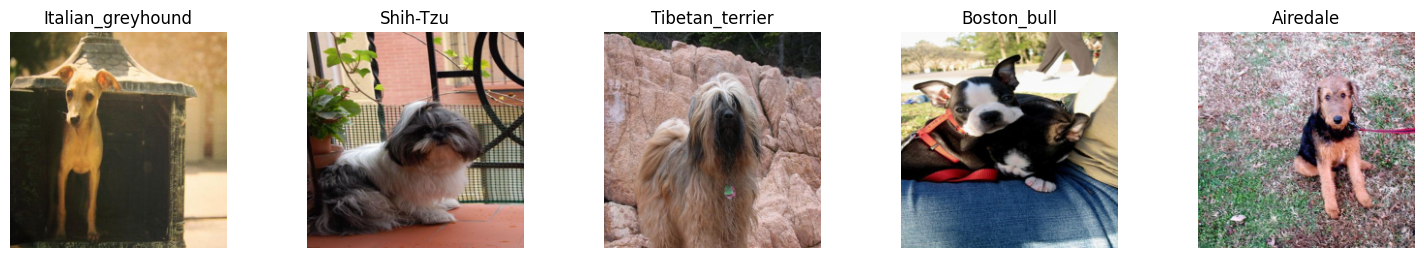

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

def show_random_images(dataset, num_images=5):
    # Set figure size
    plt.figure(figsize=(15, 5))

    # Ambil indeks random
    indices = random.sample(range(len(dataset)), num_images)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)

        class_name = dataset.classes[label] if hasattr(dataset, 'classes') else f"Class {label}"
        class_name = class_name[10:]
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Tampilkan gambar random dari dataset
show_random_images(dataset)


# **Model ResNet50**

In [8]:
def load_network(net_model, dropout_ratio, class_names, unfrozen_layers):
    for name, child in net_model.named_children():
        if name in unfrozen_layers:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True
        else:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False


    num_ftrs = net_model.fc.in_features
    net_model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                                     nn.ReLU(),
                                     nn.Dropout(p=dropout_ratio),
                                     nn.Linear(256, len(class_names)))

    display(net_model)

    total_params = sum(param.numel() for param in net_model.parameters())
    print(f'{total_params:,} total parameters')

    total_trainable_params = sum(param.numel() for param in net_model.parameters() if param.requires_grad)
    print(f'{total_trainable_params:,} training parameters')

    return net_model

In [43]:
# Load pretrained ResNet18
model = models.resnet50(pretrained=True)

# Modifikasi model
dropout_ratio = 0.5
unfrozen_layers = ['layer4', 'fc']  # Hanya layer4 dan fc yang dilatih

# Panggil fungsi
model = load_network(model, dropout_ratio, class_names, unfrozen_layers)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

24,063,416 total parameters
15,520,120 training parameters


# **Train Model**

In [44]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device='cuda'):
    model = model.to(device)

    # Initialize tracking variables
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 5

    # History for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{running_loss/len(train_loader):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

        train_loss = running_loss/len(train_loader)
        train_acc = 100.*correct/total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                val_pbar.set_postfix({
                    'loss': f'{val_loss/len(val_loader):.4f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })

        val_loss = val_loss/len(val_loader)
        val_acc = 100.*val_correct/val_total

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            # Save best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'class_names': class_names
            }, 'best_model.pth')
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs')
            break

    return model, history

In [45]:
def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/30 [Train]:   0%|          | 0/161 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/30 [Val]: 100%|██████████| 81/81 [00:43<00:00,  1.85it/s, loss=2.2396, acc=34.93%]



Epoch 1/30:
Train Loss: 3.3927, Train Acc: 17.23%
Val Loss: 2.2396, Val Acc: 34.93%


Epoch 2/30 [Val]: 100%|██████████| 81/81 [00:36<00:00,  2.24it/s, loss=1.7142, acc=49.37%]



Epoch 2/30:
Train Loss: 2.1508, Train Acc: 37.40%
Val Loss: 1.7142, Val Acc: 49.37%


Epoch 3/30 [Val]: 100%|██████████| 81/81 [00:36<00:00,  2.23it/s, loss=1.5457, acc=53.06%]



Epoch 3/30:
Train Loss: 1.6467, Train Acc: 48.75%
Val Loss: 1.5457, Val Acc: 53.06%


Epoch 4/30 [Val]: 100%|██████████| 81/81 [00:36<00:00,  2.23it/s, loss=1.3510, acc=58.78%]



Epoch 4/30:
Train Loss: 1.3613, Train Acc: 56.43%
Val Loss: 1.3510, Val Acc: 58.78%


Epoch 5/30 [Val]: 100%|██████████| 81/81 [00:35<00:00,  2.25it/s, loss=1.3811, acc=59.34%]



Epoch 5/30:
Train Loss: 1.1129, Train Acc: 63.56%
Val Loss: 1.3811, Val Acc: 59.34%


Epoch 6/30 [Val]: 100%|██████████| 81/81 [00:36<00:00,  2.21it/s, loss=1.3345, acc=61.05%]



Epoch 6/30:
Train Loss: 0.9857, Train Acc: 67.28%
Val Loss: 1.3345, Val Acc: 61.05%


Epoch 7/30 [Val]: 100%|██████████| 81/81 [00:36<00:00,  2.24it/s, loss=1.2732, acc=60.86%]



Epoch 7/30:
Train Loss: 0.8420, Train Acc: 71.28%
Val Loss: 1.2732, Val Acc: 60.86%


Epoch 8/30 [Val]: 100%|██████████| 81/81 [00:36<00:00,  2.22it/s, loss=1.2972, acc=62.72%]



Epoch 8/30:
Train Loss: 0.7264, Train Acc: 75.59%
Val Loss: 1.2972, Val Acc: 62.72%


Epoch 9/30 [Val]: 100%|██████████| 81/81 [00:36<00:00,  2.21it/s, loss=1.4198, acc=62.39%]



Epoch 9/30:
Train Loss: 0.6281, Train Acc: 78.29%
Val Loss: 1.4198, Val Acc: 62.39%


Epoch 10/30 [Val]: 100%|██████████| 81/81 [00:36<00:00,  2.23it/s, loss=1.4049, acc=63.42%]



Epoch 10/30:
Train Loss: 0.5780, Train Acc: 80.30%
Val Loss: 1.4049, Val Acc: 63.42%


Epoch 11/30 [Val]: 100%|██████████| 81/81 [00:36<00:00,  2.25it/s, loss=1.4988, acc=62.33%]



Epoch 11/30:
Train Loss: 0.5082, Train Acc: 82.73%
Val Loss: 1.4988, Val Acc: 62.33%


Epoch 12/30 [Val]: 100%|██████████| 81/81 [00:36<00:00,  2.21it/s, loss=1.5875, acc=63.98%]



Epoch 12/30:
Train Loss: 0.4189, Train Acc: 85.84%
Val Loss: 1.5875, Val Acc: 63.98%

Early stopping triggered after 12 epochs


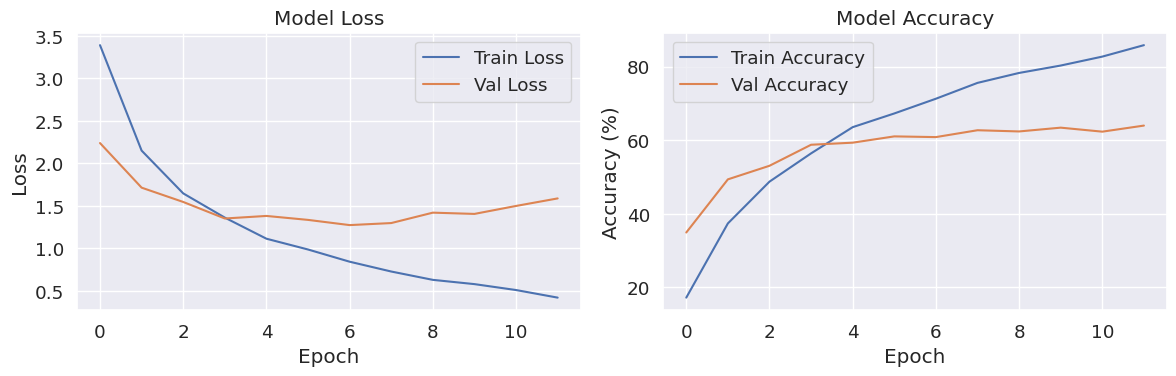

In [46]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set number of epochs
num_epochs = 30

# Train the model
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

# Plot training history
plot_training_history(history)

In [47]:
def test_model(model, test_loader):
    # model.load_state_dict(torch.load('best_model.pth'))
    checkpoint = torch.load('best_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if torch.cuda.is_available():
        model.cuda()
    model.eval()

    preds = []
    trues = []

    for i, (inputs, targets) in enumerate(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            pred = model(inputs).data.cuda().cpu().numpy().copy()
        else:
            pred = model(inputs).data.numpy().copy()

        true = targets.numpy().copy()
        preds.append(pred)
        trues.append(true)

        if i % (len(test_loader)//5) == 0:
            print(f'Iteration {i+1}/{len(test_loader)}')
    return np.concatenate(preds), np.concatenate(trues)

In [48]:
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(256, 120)
)
preds_test, y_true = test_model(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-47-577d2530b70a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Iteration 1/81
Iteration 17/81
Iteration 33/81
Iteration 49/81
Iteration 65/81
Iteration 81/81


In [49]:
def display_confusion_matrix(model_name, y_true, preds, class_names, annot, figsize=(9,7), fontsize=14):

    acc = accuracy_score(y_true, preds.argmax(1))
    score = f1_score(y_true, preds.argmax(1), average='micro')
    cm = confusion_matrix(y_true, preds.argmax(1))
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    np.set_printoptions(precision=2)

    string1 = 'Confusion Matrix for Testing Data'
    string2 = f'Accuracy is {acc:0.3f}; F1-score is {score:0.3f}'
    title_str = string1.center(len(string2))+'\n'+string2

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=annot, annot_kws={'size': fontsize}, fmt='d')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title_str)

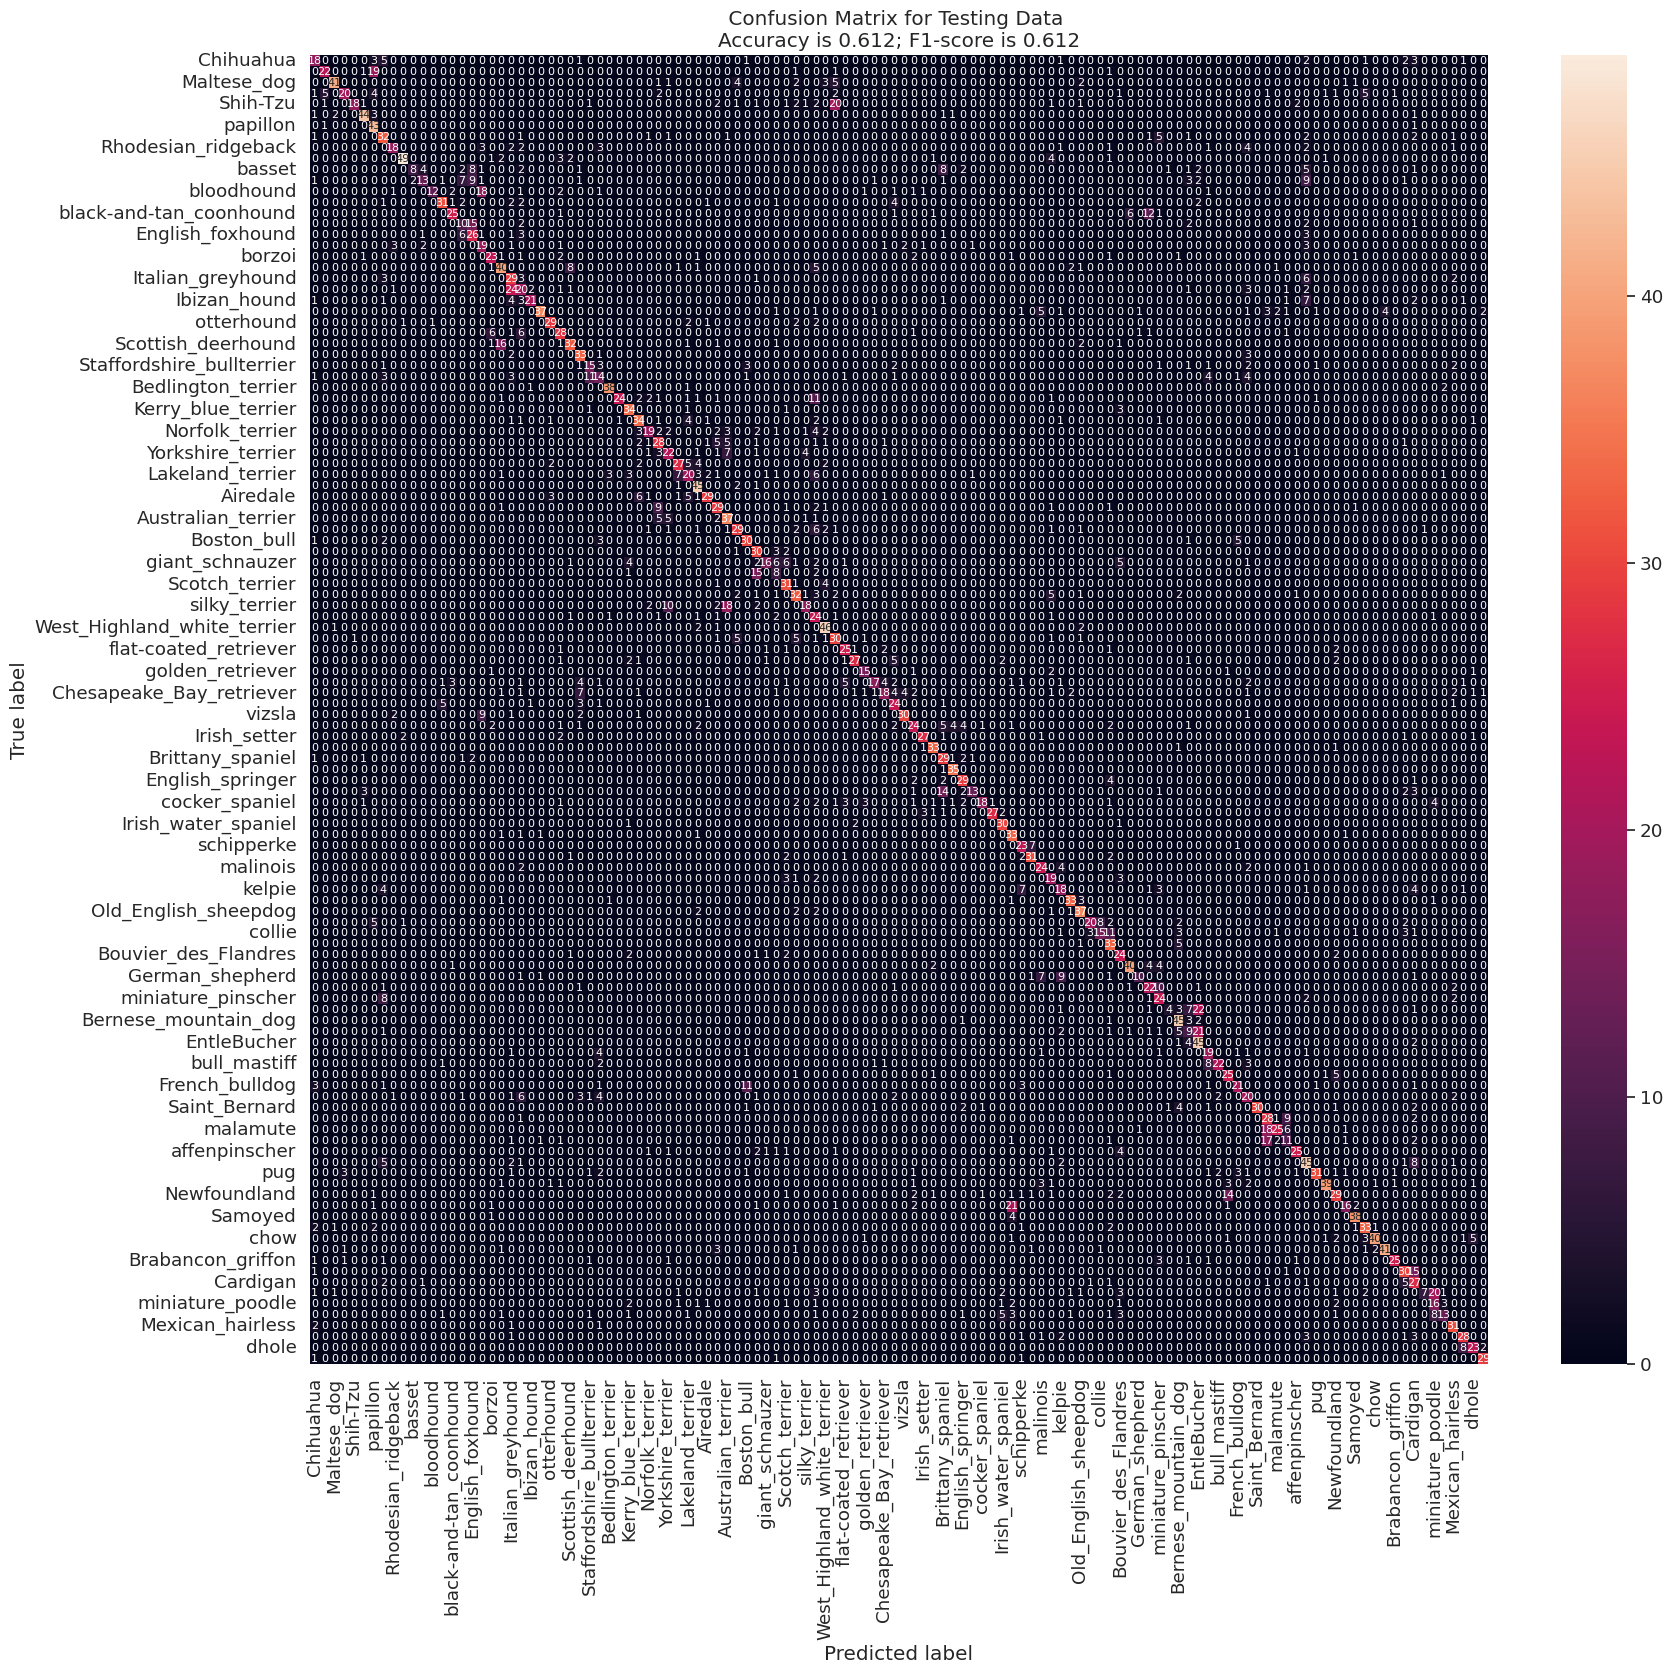

In [50]:
net_name = 'best_model.pth'
display_confusion_matrix(net_name, y_true, preds_test, class_names, annot=True, figsize=(19,17), fontsize=8)

In [51]:
print(classification_report(y_true, preds_test.argmax(1), target_names=class_names))

                                precision    recall  f1-score   support

                     Chihuahua       0.49      0.47      0.48        38
              Japanese_spaniel       0.76      0.49      0.59        45
                   Maltese_dog       0.89      0.67      0.77        61
                      Pekinese       0.80      0.45      0.58        44
                      Shih-Tzu       0.95      0.33      0.49        55
              Blenheim_spaniel       0.85      0.83      0.84        53
                      papillon       0.53      0.96      0.68        45
                   toy_terrier       0.45      0.65      0.53        49
           Rhodesian_ridgeback       0.69      0.47      0.56        38
                  Afghan_hound       0.92      0.77      0.84        64
                        basset       0.80      0.17      0.29        46
                        beagle       0.62      0.25      0.36        52
                    bloodhound       0.92      0.29      0.44  

# **Test**

In [52]:
from PIL import Image

In [53]:
def predict_image(model, image_path, class_names, device='cuda', top_k=5):
    """
    Melakukan prediksi pada single image dan menampilkan top k probabilitas
    """
    # Load dan transform image
    image = Image.open(image_path).convert('RGB')

    # Gunakan transform yang sama dengan test_transform
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Transform image
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    model.eval()

    # Prediksi
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get top k probabilities and indices
        top_prob, top_idx = torch.topk(probabilities, k=min(top_k, len(class_names)))
        top_prob = top_prob.squeeze().cpu().numpy()
        top_idx = top_idx.squeeze().cpu().numpy()

    # Get top k class names
    top_classes = [class_names[i] for i in top_idx]

    # Tampilkan hasil
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')

    # Plot probability bar untuk top k classes
    plt.subplot(1, 2, 2)
    plt.barh(range(len(top_classes)), top_prob)
    plt.yticks(range(len(top_classes)), top_classes)
    plt.xlabel('Probability')
    plt.title(f'Top {top_k} Class Probabilities')

    plt.tight_layout()
    plt.show()

    # Print hasil prediksi teratas
    print(f"\nPredicted class: {top_classes[0]}")
    print(f"Confidence: {top_prob[0]*100:.2f}%")


    return top_classes[0], top_prob[0]*100


In [54]:
# Load model
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(256, 120)
)

# Load state_dict
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
class_names = checkpoint['class_names']
model = model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-54-0bea92a141cb>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

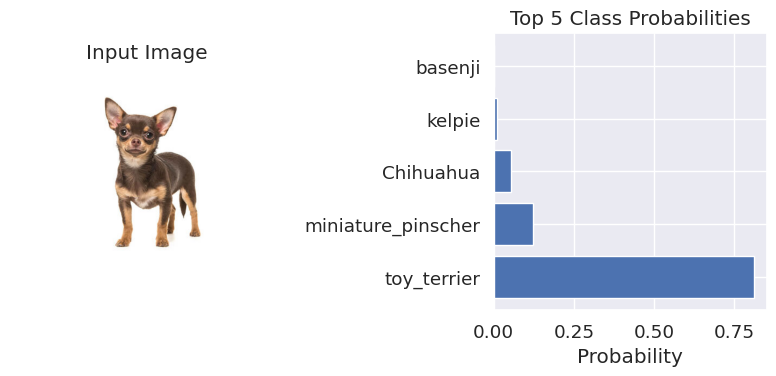


Predicted class: toy_terrier
Confidence: 81.20%


In [57]:

image_path = "test.jpg"
predicted_label, confidence = predict_image(model, image_path, class_names, device)

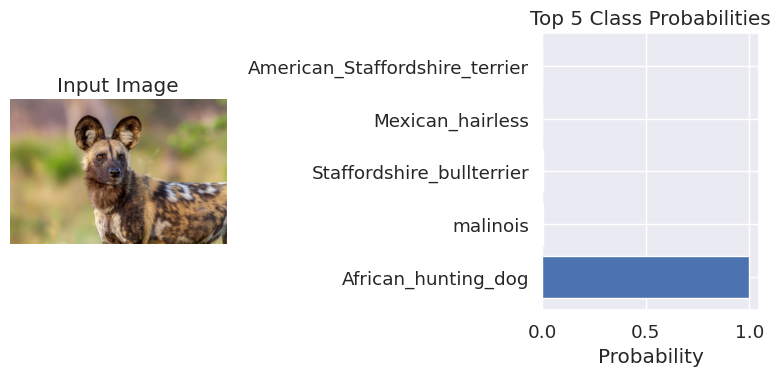


Predicted class: African_hunting_dog
Confidence: 99.75%


In [58]:

image_path = "test2.jpg"
predicted_label, confidence = predict_image(model, image_path, class_names, device)